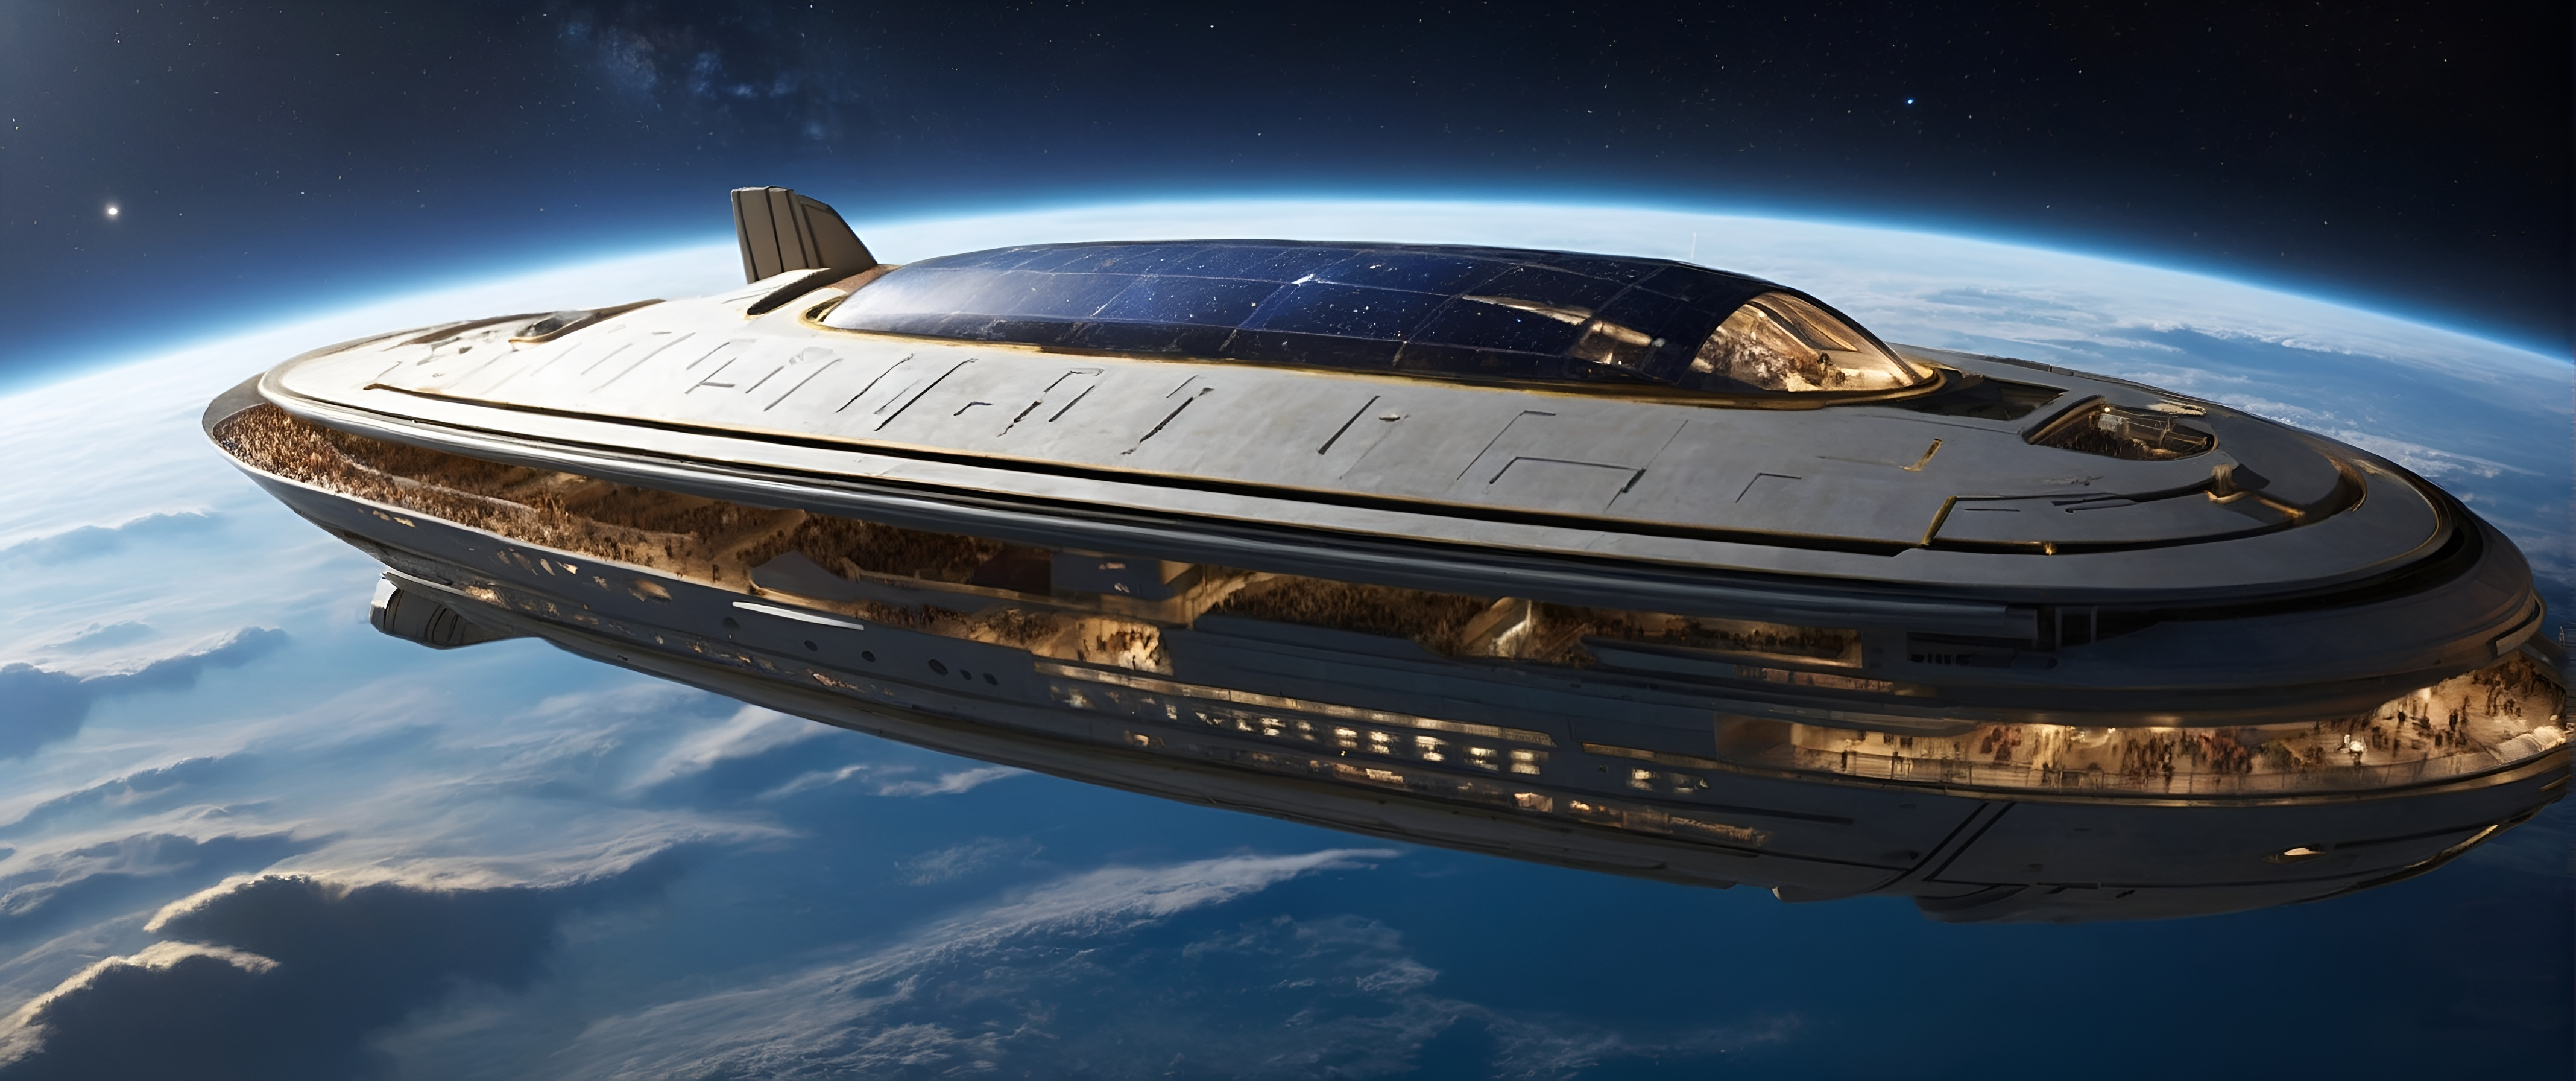

In [1]:
#Obliczenia  i analiza  danych
import numpy as np
import pandas as pd

#wizualiacja 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette('icefire_r', 2)
import warnings

%matplotlib inline
#Przetwarzanie

from sklearn.preprocessing import OrdinalEncoder

from sklearn.impute import KNNImputer
# Baza danych gównych do nauki modelu
train = pd.read_csv("train.csv") 
# Baza danych Titanica do sprawdzenia modelu
test = pd.read_csv("test.csv")

In [2]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


# Czyszczenie i przygotowanie danych

#### Przygotwanie kolumny 'Cabin' do encodowania

In [3]:
def extract_cabin_details(cabin):
  try:
    parts = cabin.split('/')
    if len(parts) == 2:
      cabin_type, deck_level = parts
      section_number = None
    elif len(parts) == 3:
      cabin_type, deck_level, section_number = parts
    else:
      raise ValueError("Nieprawidłowy format wartości w kolumnie Cabin")
    return cabin_type, int(deck_level), section_number
  except ValueError:
    return None, None, None

for df in [train, test]:
  df['Cabin_Filled'] = df['Cabin'].notna()

  # Ekstrakcja parametrów
  df.loc[df['Cabin_Filled'], 'Cabin_Type'] = df['Cabin'][df['Cabin_Filled']].apply(extract_cabin_details).str[0]
  df.loc[df['Cabin_Filled'], 'Cabin_Deck'] = df['Cabin'][df['Cabin_Filled']].apply(extract_cabin_details).str[1]
  df.loc[df['Cabin_Filled'], 'Cabin_Section'] = df['Cabin'][df['Cabin_Filled']].apply(extract_cabin_details).str[2]

  # Uzupełnianie wartości NaN
  df['Cabin_Type'].replace('NaN', np.nan, inplace=True)
  df['Cabin_Deck'].replace('NaN', np.nan, inplace=True)
  df['Cabin_Section'].replace('NaN', np.nan, inplace=True)

  # Konwersja typów
  df['Cabin_Deck'] = df['Cabin_Deck'].astype('float')
  df['Cabin_Type'] = df['Cabin_Type'].astype('category')
  df['Cabin_Section'] = df['Cabin_Section'].astype('category')

  # Usunięcie kolumny pomocniczej
  del df['Cabin_Filled']

#### Przygotwanie kolumny Name do zastępienia jej kolumną rodzina

In [4]:
for df in [train, test]:
  # Create Last_Name column, handling missing values
  df['Last_Name'] = df['Name'].str.split().str[-1].fillna(pd.NA)

In [5]:
def find_groups(df):
    groups = {}
    for name, group in df.groupby('Last_Name'):
        for cabin, subgroup in group.groupby('Cabin'):
            if len(subgroup) > 1:
                if subgroup['Family'].all():
                    subgroup['Family'] = 1
                groups[name] = list(subgroup.index)

    return groups

# Zastosowanie funkcji do DataFrame'ów test i train
for df in [test, train]:
    df['Family'] = 0
    groups = find_groups(df.copy())
    for name, group in groups.items():
        df.loc[group, 'Family'] = 1
train['Family'].value_counts()

Family
0    6513
1    2180
Name: count, dtype: int64

#### Ordinal encoding

In [6]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Enc_col = ['HomePlanet', 'CryoSleep', 'Destination' , 'VIP', 'Cabin_Type', 'Cabin_Section' ]

# Fit the encoder and create the mapping for each column separately
categories = {}
for col in Enc_col:
    for df in [train, test]:
        df[col + '_Enc'] = enc.fit_transform(df[col].values.reshape(-1, 1))
    categories[col] = enc.categories_[0]  # Store categories for the current column

# Print the mapping
for col in Enc_col:
    print(f"Kolumna: {col}")
    for i, category in enumerate(categories[col]):
        print(f"  Wartość zakodowana: {i} -> Wartość początkowa: {category}")

Kolumna: HomePlanet
  Wartość zakodowana: 0 -> Wartość początkowa: Earth
  Wartość zakodowana: 1 -> Wartość początkowa: Europa
  Wartość zakodowana: 2 -> Wartość początkowa: Mars
  Wartość zakodowana: 3 -> Wartość początkowa: nan
Kolumna: CryoSleep
  Wartość zakodowana: 0 -> Wartość początkowa: False
  Wartość zakodowana: 1 -> Wartość początkowa: True
  Wartość zakodowana: 2 -> Wartość początkowa: nan
Kolumna: Destination
  Wartość zakodowana: 0 -> Wartość początkowa: 55 Cancri e
  Wartość zakodowana: 1 -> Wartość początkowa: PSO J318.5-22
  Wartość zakodowana: 2 -> Wartość początkowa: TRAPPIST-1e
  Wartość zakodowana: 3 -> Wartość początkowa: nan
Kolumna: VIP
  Wartość zakodowana: 0 -> Wartość początkowa: False
  Wartość zakodowana: 1 -> Wartość początkowa: True
  Wartość zakodowana: 2 -> Wartość początkowa: nan
Kolumna: Cabin_Type
  Wartość zakodowana: 0 -> Wartość początkowa: A
  Wartość zakodowana: 1 -> Wartość początkowa: B
  Wartość zakodowana: 2 -> Wartość początkowa: C
  Wartoś

In [7]:
# Wspolny sufix przy bilecie
for df in [test, train]:
    group = df['PassengerId'].apply(lambda x: x.split('_')[0]).value_counts().to_dict()
    df['Group'] = df['PassengerId'].apply(lambda x: group[x.split('_')[0]])

#### Sprzątanie

In [8]:
categorical_features = ['PassengerId','HomePlanet', 'CryoSleep', 'Cabin', 'Destination' , 'Name', 'VIP', 'Cabin_Type', 'Last_Name', 'Cabin_Section']
for df in [train, test]:
     df.drop(columns=categorical_features, inplace=True)
print(pd.isnull(train).sum())

Age                  179
RoomService          181
FoodCourt            183
ShoppingMall         208
Spa                  183
VRDeck               188
Transported            0
Cabin_Deck           199
Family                 0
HomePlanet_Enc       201
CryoSleep_Enc        217
Destination_Enc      182
VIP_Enc              203
Cabin_Type_Enc       199
Cabin_Section_Enc    199
Group                  0
dtype: int64


In [9]:
train.groupby('Transported').mean().round(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Family,HomePlanet_Enc,CryoSleep_Enc,Destination_Enc,VIP_Enc,Cabin_Type_Enc,Cabin_Section_Enc,Group
Transported,,,,,,,,,,,,,,,
False,29.92,389.27,382.62,167.57,564.38,543.63,623.62,0.2,0.57,0.13,1.57,0.03,4.51,0.45,1.90
True,27.75,63.10,532.69,179.83,61.68,69.15,577.45,0.3,0.76,0.58,1.39,0.02,4.10,0.56,2.17


#### Uzupełnianie brakujących wartości

In [10]:
def fill_missing_values(df, column_to_exclude='Transported'):
 # Exclude the specified column from imputation
    cols_to_impute = [col for col in df.columns if col != column_to_exclude and df[col].isna().any()]

    # Create KNN Imputer with 5 neighbors
    imputer = KNNImputer(n_neighbors=6)

    # Impute values in the selected columns
    df_imputed = df[cols_to_impute].copy()  # Avoid modifying original DataFrame
    df_imputed = imputer.fit_transform(df_imputed)

    # Assign imputed values back to the selected columns in the original DataFrame
    df[cols_to_impute] = df_imputed

    # Return the imputed DataFrame and original column order (excluding the excluded column)
    return df, [col for col in df.columns if col != column_to_exclude]

# Combine train and test DataFrames (assuming 'Transported' is a string column)
combined_df = pd.concat([train, test], ignore_index=True)

# Impute missing values in the combined DataFrame
combined_df_imputed, cols_without_excluded = fill_missing_values(combined_df)

# Split the imputed DataFrame back to train and test
train_imputed = combined_df_imputed.iloc[:len(train)]
test_imputed = combined_df_imputed.iloc[len(train):]

# Restore original column order for train and test
train = train_imputed[cols_without_excluded].assign(Transported=train['Transported'])  # Assign 'Transported' back to train
test = test_imputed[cols_without_excluded]

# Check for missing values after imputation
print(pd.isnull(train_imputed).sum())
print(pd.isnull(test_imputed).sum())

Age                  0
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
Transported          0
Cabin_Deck           0
Family               0
HomePlanet_Enc       0
CryoSleep_Enc        0
Destination_Enc      0
VIP_Enc              0
Cabin_Type_Enc       0
Cabin_Section_Enc    0
Group                0
dtype: int64
Age                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Transported          4277
Cabin_Deck              0
Family                  0
HomePlanet_Enc          0
CryoSleep_Enc           0
Destination_Enc         0
VIP_Enc                 0
Cabin_Type_Enc          0
Cabin_Section_Enc       0
Group                   0
dtype: int64


In [11]:
# Suma wydatków
for df in [test, train]:
    df['TotalSpending'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']

#### Modele standaryzujące

In [12]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer

# Wybór kolumn do standaryzacji
kolumny = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpending' , 'TotalSpending', 'Cabin_Deck']

# # Tworzenie obiektu StandardScaler
# scaler = RobustScaler()
# # Dopasowanie i transformacja danych treningowych
# scaler.fit(train[kolumny])
# train_scaled = scaler.transform(train[kolumny])
# # Transformacja danych testowych
# test_scaled = scaler.transform(test[kolumny])
# # Dodanie przetworzonych kolumn do data frame
# for df in [train, test]:
#   df[kolumny] = scaler.transform(df[kolumny])
## -------------------------------------------------------------
# scaler = MinMaxScaler()
# scaler.fit(train[kolumny])
# train_scaled = scaler.transform(train[kolumny])
# test_scaled = scaler.transform(test[kolumny])

# for df in [train, test]:
#     df[kolumny] = scaler.transform(df[kolumny])
## ----------------------------------------------------------------
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
scaler.fit(train[kolumny])
train_scaled = scaler.transform(train[kolumny])
test_scaled = scaler.transform(test[kolumny])

for df in [train, test]:
    df[kolumny] = scaler.transform(df[kolumny])
    

#### PolynomialFeatures

In [13]:
train.columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Cabin_Deck', 'Family', 'HomePlanet_Enc', 'CryoSleep_Enc',
       'Destination_Enc', 'VIP_Enc', 'Cabin_Type_Enc', 'Cabin_Section_Enc',
       'Group', 'Transported', 'TotalSpending'],
      dtype='object')

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from itertools import combinations
from scipy.stats import pearsonr
from sklearn.feature_selection import SelectKBest
warnings.simplefilter('ignore')

kolumny = [kolumna for kolumna in train.columns]
df= train

def znajdz_najlepsza_interakcje(df, kolumny):
  wyniki = pd.DataFrame(columns=['Najlepsza_para', 'Interakcja', 'Korelacja'])

  for kolumny_para in combinations(kolumny, 2):
    # Utwórz obiekt PolynomialFeatures
    poly = PolynomialFeatures(degree=2, interaction_only=True)

    # Dopasuj i transformuj dane
    X = poly.fit_transform(pd.concat([df[kolumny_para[0]], df[kolumny_para[1]]], axis=1))

    # Dodaj nazwę interakcji jako nową kolumnę
    interakcja = f'Interakcja_{"_".join(kolumny_para)}'
    df[interakcja] = X[:, -1]

    # Oblicz korelację z Transported
    korelacja = df[interakcja].corr(df['Transported'])

    # Dodaj wiersz do wyników
    wyniki.loc[len(wyniki)] = {
        'Najlepsza_para': kolumny_para,
        'Interakcja': interakcja,
        'Korelacja': korelacja,
    }

  return wyniki

# Przykład użycia
kolumny = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_Deck', 
            'Family', 'HomePlanet_Enc',
            'CryoSleep_Enc', 'Destination_Enc', 'VIP_Enc', 'Cabin_Type_Enc',
            'Cabin_Section_Enc','Group', 'TotalSpending']

wyniki = znajdz_najlepsza_interakcje(df.copy(), kolumny)

# Sortuj wyniki według korelacji
wyniki = wyniki.sort_values('Korelacja', ascending=False)

# Wybierz parę kolumn z najwyższą korelacją
najlepsza_para = wyniki.iloc[0]['Najlepsza_para']

# Wyświetl informacje o najlepszej parze
# print(f"Najlepsza para kolumn: {najlepsza_para}")
# print(f"Korelacja: {wyniki.iloc[0]['Korelacja']}")
wyniki.to_csv('wyniki.csv', index=False)

In [15]:
from sklearn.preprocessing import PolynomialFeatures
kolumny = ['HomePlanet_Enc', 'CryoSleep_Enc']  # Ensure these names match both dataframes

# Create PolynomialFeatures object
poly = PolynomialFeatures(degree=2, interaction_only=True) #interaction_only=True

# Dodaj nową kolumnę do każdego dataframu
for df in [train, test]:
    # Dopasuj i transformuj dane
    X = poly.fit_transform(df[kolumny])

    # Dodaj nazwę interakcji jako nową kolumnę
    df['Interakcja1'] = X[:, -1]  # Zakłada, że ostatnia kolumna zawiera interakcję

#train.groupby('Transported').corr().round(2)

In [16]:
kolumny = ['Family', 'Cabin_Section_Enc']  # Ensure these names match both dataframes

# Create PolynomialFeatures object
poly = PolynomialFeatures(degree=2, interaction_only=True) #interaction_only=True

# Dodaj nową kolumnę do każdego dataframu
for df in [train, test]:
    # Dopasuj i transformuj dane
    X = poly.fit_transform(df[kolumny])

    # Dodaj nazwę interakcji jako nową kolumnę
    df['Interakcja2'] = X[:, -1]  # Zakłada, że ostatnia kolumna zawiera interakcję

# Wizualizacja

Text(0.5, 1.05, 'Macierz korelacji Perasona')

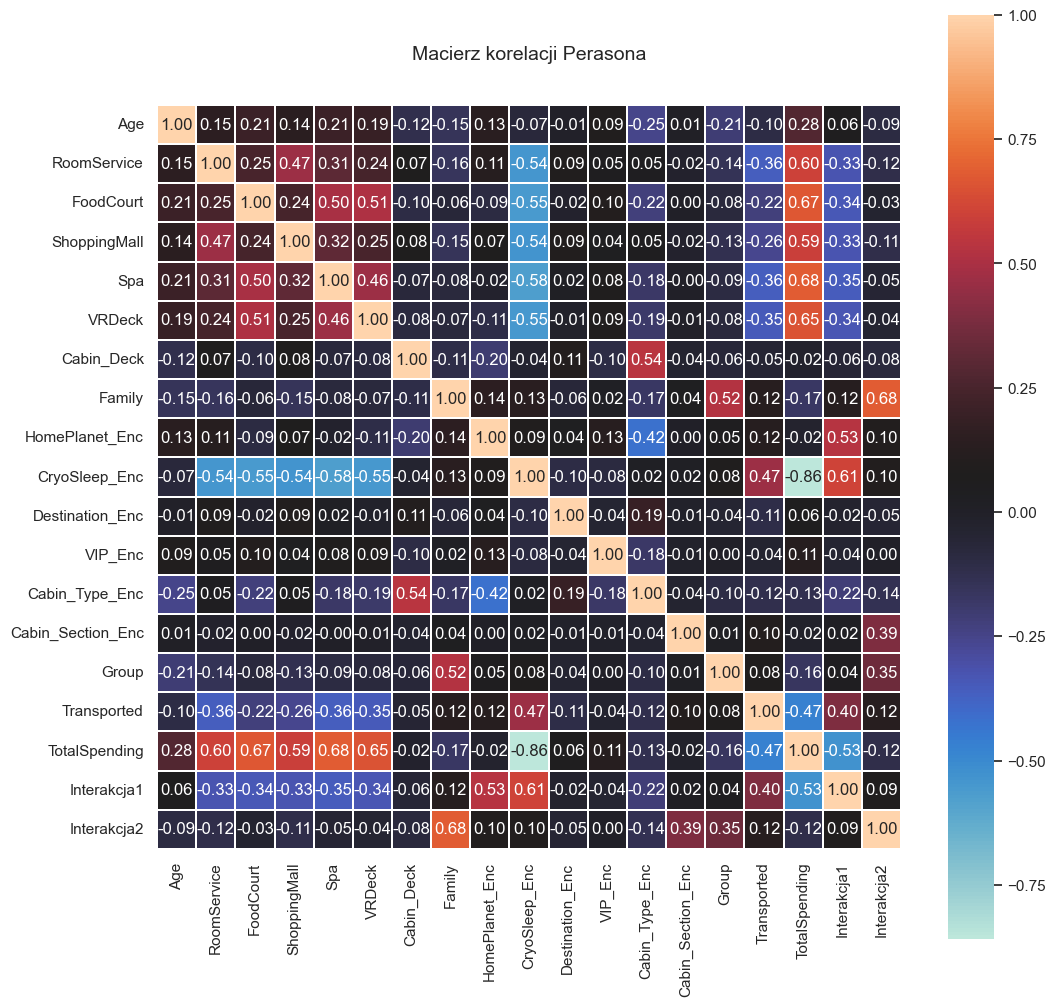

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, linecolor='white', annot=True, cmap= 'icefire', fmt=".2f")
ax.set_title('Macierz korelacji Perasona', y=1.05,   size=14)

In [18]:
train.groupby('Transported').mean().round(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Family,HomePlanet_Enc,CryoSleep_Enc,Destination_Enc,VIP_Enc,Cabin_Type_Enc,Cabin_Section_Enc,Group,TotalSpending,Interakcja1,Interakcja2
Transported,,,,,,,,,,,,,,,,,,
False,0.06,-1.91,-2.27,-2.27,-1.75,-1.91,0.05,0.2,0.57,0.14,1.57,0.03,4.52,0.45,1.90,-0.38,0.04,0.09
True,-0.17,-4.10,-3.61,-3.81,-3.94,-4.01,-0.05,0.3,0.76,0.59,1.39,0.02,4.10,0.56,2.17,-3.16,0.51,0.18


# Modele Predykcyjne

In [19]:
#Biblioteki
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics         import make_scorer, f1_score, accuracy_score

from sklearn.neural_network  import MLPClassifier

from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import AdaBoostClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.ensemble        import HistGradientBoostingClassifier

from sklearn.svm             import NuSVC, SVC, LinearSVC


from catboost                import CatBoostClassifier, CatBoostRegressor
from xgboost                 import XGBClassifier

SKfold = RepeatedStratifiedKFold(n_splits=4, n_repeats=4)


In [20]:
#Baza danych
X_train = train.drop('Transported',axis=1)
y_train = train['Transported']

X_test = test
y_test = []

testt = pd.read_csv("test.csv")
submission_df1 = pd.DataFrame({"PassengerId": testt['PassengerId']})

In [21]:
#Modele które zostaną wykorzystane
classifiers = [['Random Forest',RandomForestClassifier()],
               ['AdaBoost',AdaBoostClassifier(algorithm='SAMME')],
               ['Gradient Boosting',GradientBoostingClassifier()],
               ['Support Vector Machine', NuSVC()], 
               ['HGBC',HistGradientBoostingClassifier()], 
               ['Cat', CatBoostClassifier(verbose=False)],
               ['XGBC', XGBClassifier()],
               ['MLPClas', MLPClassifier()]
              ]

#### First check

In [22]:
# ## Wstępna ocena wydajności modeli z domyślnymi parametrami
# scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}
# warnings.simplefilter('ignore')

# for metric in ['accuracy','f1']:
#     SKfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
#     score_mean = []
#     std = []
    
#     for model in classifiers:
#         clf = model[1]
#         cv_result = cross_val_score(clf,X_train, y_train, cv = SKfold, scoring = metric, n_jobs=-1)
#         cv_result = cv_result
#         score_mean.append(cv_result.mean())
#         std.append(cv_result.std())
        
#     models_evaluation = pd.DataFrame({metric: score_mean}, index=[i[0] for i in classifiers])
#     print(models_evaluation.sort_values(metric, ascending=False))
#     print('*'*32)

### Fine tuning

#### Sklern models

In [23]:
# from sklearn.metrics import accuracy_score, f1_score, make_scorer

# param_grids = {
#     'Random Forest': {
#         'n_estimators': [75, 100, 125, 150, 175, 200, 225, 250, 300, 325, 350],
#         'max_depth': [7, 8, 9, 10 ,11, 12 ,13, 14, 15, 16]
#     },
#     'AdaBoost': {
#         'n_estimators': [125 , 140, 155, 170, 185, 205, 220, 235],
#         'learning_rate': [0.60, 0.65, 0.70, 0.75, 0.80, 0.85,]
#     },
#     'Gradient Boosting': {
#         'n_estimators': [75, 100, 125, 150, 175, 200, 225, 250],
#         'learning_rate': [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, ]
#     },
#     'Support Vector Machine': {
#         'nu': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65],
#         'kernel': ['rbf', 'sigmoid']
#     },
#     'HGBC': {
#         'learning_rate': [0.0075, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2]
#     }
# }

# classifiers = [['Random Forest',RandomForestClassifier()],
#                ['AdaBoost',AdaBoostClassifier(algorithm='SAMME')],
#                ['Gradient Boosting',GradientBoostingClassifier()],
#                ['Support Vector Machine', NuSVC()], 
#                ['HGBC',HistGradientBoostingClassifier()],           
#               ]


# # Perform GridSearchCV for each classifier with accuracy evaluation
# for name, clf in classifiers:
#     param_grid = param_grids[name]
#     scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}
#     grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[name], cv=SKfold, scoring=scoring, refit='accuracy', n_jobs=-1)
  
#     grid_search.fit(X_train, y_train)

#     # Print the best model's accuracy and parameters
#     best_model = grid_search.best_estimator_
#     best_score = grid_search.best_score_
#     best_params = grid_search.best_params_

#     print(f"\n{name} Model:")
#     print(f"Best Accuracy on Training Data: {best_score:.4f}")
#     print(f"Best Parameters: {best_params}")

#### MLPC 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
import numpy as np

# Method 1 (directly define tuples)
hidden_layer_sizes = [
    (x, y, z)
    for x in range(34, 132, 4)
    for y in range(34, 132, 4)
    for z in range(34, 132, 4)
]

# Create the parameter grid for hyperparameter search
param_grids = {
    'MLPClas': {
        'learning_rate_init': [0.04, 0.025, 0.015, 0.0125, 0.01, 0.0075],
        'alpha': [0.0075, 0.01, 0.02, 0.035, 0.045, 0.06, 0.075 ],
        'activation': ['relu'],
        'hidden_layer_sizes': hidden_layer_sizes,
    }
}
# Define the classifiers to explore
classifiers = [['MLPClas', MLPClassifier(max_iter=800, early_stopping=True)]]

# Perform randomized search for each classifier
for name, clf in classifiers:
    param_grid = param_grids[name]

    # Create scoring dictionary with custom scorers
    scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}

    # Set up RandomizedSearchCV with early stopping for efficiency
    grid_search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_grid,
        cv=SKfold,  # Cross-validation for robust selection
        scoring=scoring,
        refit='accuracy',
        n_jobs=-1,  # Use all cores for parallelization (if memory allows)
        n_iter=400,
        verbose=2,  # Verbose output for progress tracking
        error_score=0
    )

    # Early stopping within RandomizedSearchCV for faster training
    grid_search.fit(X_train, y_train)

    # Print the best model's performance and parameters
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    print(f"\n{name} Model:")
    print(f"Best Accuracy on Training Data: {best_score:.4f}")
    print(f"Best Parameters: {best_params}")


Fitting 16 folds for each of 400 candidates, totalling 6400 fits


#### CatBoost classifier hypertuning

In [ ]:
# # define the hyperparameter search space
# param_distributions = {
#     'depth':  np.arange(4, 17, 2),
#     'learning_rate': np.arange(0.005, 0.025, 0.005),
#     'l2_leaf_reg': np.arange(0.005, 0.065, 0.01),
#     'max_bin': np.arange(50, 250, 25),
#     'one_hot_max_size': np.arange(5, 75, 10),
# }

# # create a CatBoostClassifier model with default parameters
# model = CatBoostClassifier(verbose=False)

# # perform random search with cross-validation
# grid_search = RandomizedSearchCV(model, param_distributions=param_distributions, cv=SKfold, scoring=scoring, refit='accuracy', n_jobs=-1)

# # Fit the RandomizedSearchCV object to the training data
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and corresponding mean cross-validation score
# print("Best hyperparameters: ", grid_search.best_params_)
# print("Best mean cross-validation score: {:.4f}".format(grid_search.best_score_))

# # Evaluate the best model on the test data
# best_model = grid_search.best_estimator_
# print(best_model)

#### XGBoost classifier hypertuning

In [ ]:
# # Set up the XGBoost classifier with default hyperparameters
# scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}

# model = XGBClassifier()

# # Define the hyperparameters to tune and their search ranges
# param_dist = {
#   'n_estimators': np.arange(150, 1200, 50),
#   'max_depth': np.arange(4, 16, 1),
#   'learning_rate': np.arange(0.005, 0.065, 0.01),
#   'subsample': np.arange(0.4, 1.0, 0.1),
#   'min_child_weight': np.arange(1, 10, 1),
#   'reg_alpha': np.arange(0, 1, 0.1),
#   'reg_lambda': np.arange(0, 1, 0.1),
# }

# # Set up the RandomizedSearchCV object with cross-validation
# grid_search = RandomizedSearchCV(model, param_distributions=param_dist, cv=SKfold, scoring=scoring, refit='accuracy', n_jobs=-1)

# # Fit the RandomizedSearchCV object to the training data
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and corresponding mean cross-validation score
# print("Best hyperparameters: ", grid_search.best_params_)
# print("Best mean cross-validation score: {:.4f}".format(grid_search.best_score_))

# # Evaluate the best model on the test data
# best_model = grid_search.best_estimator_
# print(best_model)

#### StackingClassifier with best param fitting for meta-estimator

In [ ]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression , RidgeClassifier
# #from sklearn import model_selection
# from sklearn.model_selection import  cross_val_score
# from sklearn.metrics import accuracy_score  
# warnings.simplefilter('ignore')
# SKfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)


# # Define base models (consider adding more based on your problem)
# estimators = [
#     ('Random Forest', RandomForestClassifier(n_estimators=350, max_depth=13)),
#     ('Ada Boost', AdaBoostClassifier(learning_rate=0.85, n_estimators=235, algorithm='SAMME')),
#     ('Gradient Boosting', GradientBoostingClassifier(n_estimators=150, learning_rate=0.125)),
#     ('CatBoost', CatBoostClassifier(verbose=False, iterations=2000, one_hot_max_size =45, max_bin= 200, learning_rate= 0.01, l2_leaf_reg= 0.025, depth= 6)),
#     ('HGBC', HistGradientBoostingClassifier(learning_rate=0.075)),
#     ('SVC', NuSVC(nu=0.45, kernel= 'rbf')),
#     ('XGBC', XGBClassifier(subsample = 0.7, reg_lambda = 0.2, reg_alpha = 0.2, n_estimators = 600, min_child_weight= 5, max_depth= 6, learning_rate =0.025)),
#     ('MLPClas', MLPClassifier(activation= 'relu', alpha= 0.0001, hidden_layer_sizes= (12, 12, 12), learning_rate_init= 0.025, max_iter= 8000, solver= 'adam'))
# ]

# # Hyperparameter grid for RidgeClassifier
# alphas  = [0.94, 0.945, 0.95, 0.955, 0.96, 1.045, 1.055]

# # Create an empty list to store the scores for each alpha value
# scores = []

# # Perform cross-validation for each alpha value
# for alpha in alphas:
#     # Create a RidgeClassifier with the current alpha value
#     ridge_clf = LinearSVC(C=alpha)

#     # Wrap RidgeClassifier as the final estimator
#     final_estimator = ridge_clf

#     # Create a StackingClassifier with the current final estimator
#     clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

#     # Perform cross-validation and store the score
#     scores = cross_val_score(clf, X_train, y_train, cv=SKfold, scoring='accuracy', n_jobs=-1)

#     # Calculate mean and standard deviation of the scores
#     mean_score = scores.mean()
#     std_dev = scores.std()

#     # Print the scores for the current alpha value
#     print(f"Alpha: {alpha}, Mean Score: {mean_score:.4f}, Std. Dev.: {std_dev:.4f}")

## Stacking Final estimaton

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression , RidgeClassifier
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import accuracy_score  

estimators = [
    ('Random Forest', RandomForestClassifier(n_estimators=225, max_depth=11)),
    ('Ada Boost', AdaBoostClassifier(learning_rate=0.85, n_estimators=235, algorithm='SAMME')),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=150, learning_rate=0.125)),
    ('CatBoost', CatBoostClassifier(verbose=False, iterations=2000, one_hot_max_size =45, max_bin= 200, learning_rate= 0.01, l2_leaf_reg= 0.025, depth= 6)),
    ('HGBC', HistGradientBoostingClassifier(learning_rate=0.125)),
    ('SVC', NuSVC(nu=0.45, kernel= 'rbf')),
    ('XGBC', XGBClassifier(subsample = 0.7, reg_lambda = 0.2, reg_alpha = 0.2, n_estimators = 600, min_child_weight= 5, max_depth= 6, learning_rate =0.025)),
    ('MLPClas', MLPClassifier())
]
#activation= 'relu', alpha= 0.045, hidden_layer_sizes= (126, 114, 106), learning_rate_init= 0.0125, max_iter= 8000, solver= 'adam'
# Final estimator
final_estimator = RidgeClassifier(alpha=0.715)
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

# Perform cross-validation for each model and the StackingClassifier
for name, model in estimators:
    scores = cross_val_score(model, X_train, y_train, cv=SKfold, scoring='accuracy', n_jobs=-1)
    print(f"{name}: {scores.mean():.3f} (+/- {scores.std():.3f})")
clf.fit(X_train,y_train) 

scores = cross_val_score(clf, X_train, y_train, cv=SKfold, scoring='accuracy', n_jobs=-1)
print(f"Stacking Classifier: {scores.mean():.3f} (+/- {scores.std():.3f})")

y_pred = clf.predict(X_test)

submission_df1['Transported'] = y_pred.astype('bool')
submission_df1 = submission_df1[['PassengerId', 'Transported']]
submission_df1.to_csv('submission1.csv', index=False)

# Ula lala
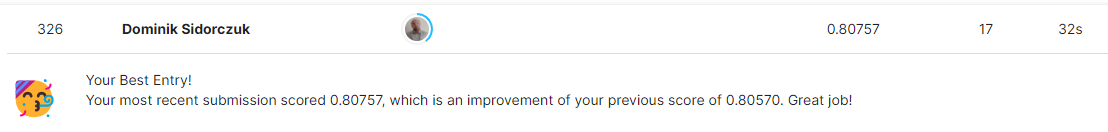